# This colab is used to load rosbag and make a perception with FCN and can store into hdf5 , image topic type of bag can be sensor/Image or sensor/CompressedImage.

# Install ROS

In [ ]:
%%bash
sh -c 'echo "deb http://packages.ros.org/ros/ubuntu $(lsb_release -sc) main" > /etc/apt/sources.list.d/ros-latest.list'
apt-key adv --keyserver 'hkp://keyserver.ubuntu.com:80' --recv-key C1CF6E31E6BADE8868B172B4F42ED6FBAB17C654
apt update  &> /dev/null
apt install ros-melodic-ros-base &> /dev/null

sudo rosdep init  &> /dev/null
rosdep update  &> /dev/null

apt install python-rosinstall  &> /dev/null
apt install python-catkin-tools  &> /dev/null
apt install ros-melodic-ros-numpy ros-melodic-vision-opencv &> /dev/null

Executing: /tmp/apt-key-gpghome.b0dsONTldj/gpg.1.sh --keyserver hkp://keyserver.ubuntu.com:80 --recv-key C1CF6E31E6BADE8868B172B4F42ED6FBAB17C654


gpg: key F42ED6FBAB17C654: public key "Open Robotics <info@osrfoundation.org>" imported
gpg: Total number processed: 1
gpg:               imported: 1


In [ ]:
import sys
import os
import time

sys.path.append('/opt/ros/melodic/lib/python2.7/dist-packages/')
print(sys.path)

os.environ['PATH'] += ':/opt/ros/melodic/bin'
print(os.environ['PATH'])

['', '/env/python', '/usr/lib/python36.zip', '/usr/lib/python3.6', '/usr/lib/python3.6/lib-dynload', '/usr/local/lib/python3.6/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.6/dist-packages/IPython/extensions', '/root/.ipython', '/opt/ros/melodic/lib/python2.7/dist-packages/']
/usr/local/nvidia/bin:/usr/local/cuda/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/tools/node/bin:/tools/google-cloud-sdk/bin:/opt/bin:/opt/ros/melodic/bin


In [ ]:
!pip install rospkg
!pip install pycryptodomex
!pip install gnupg

     |████████████████████████████████| 81kB 8.5MB/s 
     |████████████████████████████████| 13.7MB 247kB/s 
     |████████████████████████████████| 102kB 11.3MB/s 
  Created wheel for gnupg: filename=gnupg-2.3.1-cp36-none-any.whl size=94606 sha256=6b745c707792aa2b61252c7aaeffc3539baf904a422159ba68d611dcac6b0e7c
  Stored in directory: /root/.cache/pip/wheels/a8/7c/24/75dde86fabe7aa24e6e8146f20eccb2579c09ca6ad611a2630
Successfully built gnupg


In [ ]:
import re
import math
import numpy as np
from tqdm import tqdm, trange
import matplotlib.pyplot as plt
import rosbag
import h5py
import ros_numpy
from sensor_msgs.msg import Image, PointCloud2, PointField
from cv_bridge import CvBridge, CvBridgeError
import matplotlib.pyplot as plt
import cv2
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

Failed to load Python extension for LZ4 support. LZ4 compression will not be available.


Get immage from bag and store in list

In [ ]:
def get_image_list(height,weight,channels,bag_path,topic):
  imgs = []
  b = rosbag.Bag(bag_path,'r')
  for topic, msg, t in b.read_messages(topic):
      img = ros_numpy.image.image_to_numpy(msg)
      img = cv2.resize(img, (weight, height), interpolation=cv2.INTER_AREA)
      imgs.append(img)
  return imgs

Read image from hdf5 and store to list

In [ ]:
def read_img(path):
    f = h5py.File(path,'r')
    img_st = []
    for key in f.keys():
       print(key)
       print(f[key].name)
       print(f[key].shape)
       img_st.append(f[key].value)
    return img_st

Input image list and write to hdf5

In [ ]:
def write_hdf5(image,outfile):
    with h5py.File(outfile,'w') as f:      
        f['image'] = image

Prepare bag file

Example of sensor/Image

In [ ]:
import gdown
%cd /content/
%mkdir -p /content/bags
%cd /content/bags
dataset_url = 'https://drive.google.com/u/1/uc?id=1zCMv2-eSARCszz-ZvxmljvbEfrfJ62RD&export=download'
dataset_name = 'rosbag'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.bag', quiet=False)

print("Finished downloading dataset.")

/content
/content/bags


Downloading...
From: https://drive.google.com/u/1/uc?id=1zCMv2-eSARCszz-ZvxmljvbEfrfJ62RD&export=download
To: /content/bags/rosbag.bag
1.58GB [00:12, 130MB/s]


Finished downloading dataset.


Example of sensor/CompressedImage

In [ ]:
import gdown
%mkdir -p /content/bags
%cd /content/bags
dataset_url = 'https://drive.google.com/u/1/uc?id=1sg13UVfFZvO5k_6JuSbzKBJZtibvDZyE&export=download'
dataset_name = 'a_lvl_2_split'
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.bag', quiet=False)

print("Finished downloading dataset.")

/content/bags


Downloading...
From: https://drive.google.com/u/1/uc?id=1sg13UVfFZvO5k_6JuSbzKBJZtibvDZyE&export=download
To: /content/bags/a_lvl_2_split.bag
350MB [00:02, 156MB/s]


Finished downloading dataset.


In [ ]:
Bag_path = '/content/bags'
bags = os.listdir(Bag_path)[::-1]
bags.sort()

Show rosbag informations

In [ ]:
for b_name in bags:
  if b_name != '.ipynb_checkpoints':
    print(rosbag.Bag(Bag_path+'/'+b_name))

If bag doesn't contain sensor/Image but sensor/CompressedImage , use this function to do converting compressedImage to image.

In [ ]:
bag_path = '/content/bags/a_lvl_2_split.bag'
topic = '/chinook/multisense/left/image_rect_color/compressed'

In [ ]:
def readImage(topic_name,bag_path):  
    bag  = rosbag.Bag(bag_path)
    lis = []

    bridge = CvBridge()

    for topic, msg, t in bag.read_messages(topics=topic_name):
        try:
            np_arr = np.fromstring(msg.data, np.uint8)
            cv_image = cv2.imdecode(np_arr, cv2.IMREAD_COLOR)
            lis.append(cv_image)
        except CvBridgeError as e:
            print('e')
    return lis

create hdf5 of topic

In [ ]:
temp = readImage(topic,bag_path)
write_hdf5(np.array(temp),'/content/compressdimage_data.hdf5')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  if __name__ == '__main__':


read hdf5 file

In [ ]:
output_file = '/content/compressdimage_data.hdf5'
compressed_Img = read_img(output_file)

image
/image
(300, 544, 1024, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


randomly show

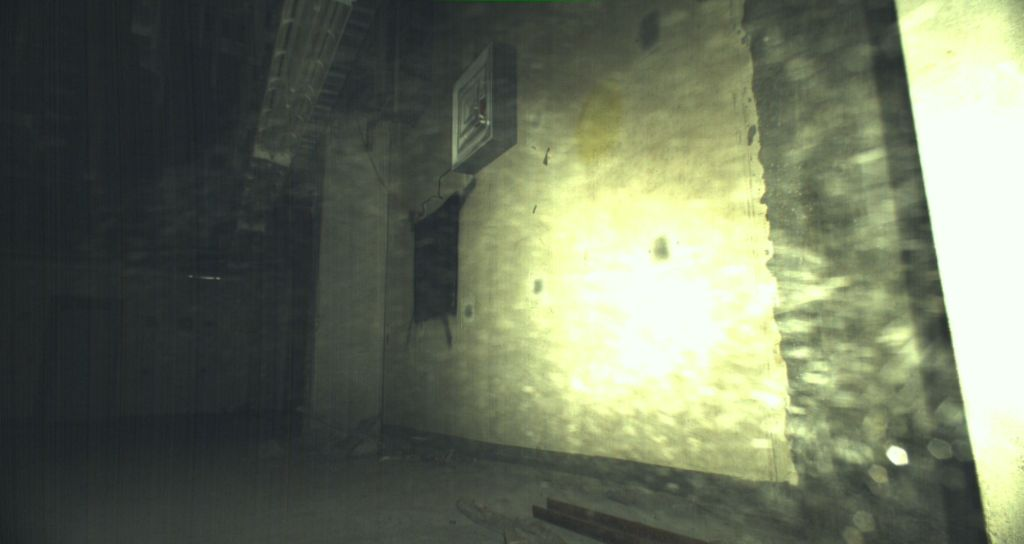

In [ ]:
compressed_image_list = np.array(compressed_Img)
cv2_imshow(compressed_image_list[0][270])

If bag contain sensor/Image.

In [ ]:
bag_path = '/content/bags/rosbag.bag'
topic = '/camera/color/image_raw'

create hdf5 of topic

In [ ]:
Image = get_image_list(256,256,3,bag_path,topic)
write_hdf5(Image,'/content/Image_data.hdf5')

read hdf5 file

In [ ]:
output_file = '/content/Image_data.hdf5'
Img = read_img(output_file)

image
/image
(1029, 256, 256, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


randomly show

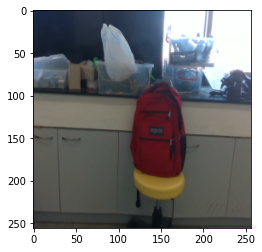

In [ ]:
image_list = np.array(Img)
plt.imshow(image_list[0][0])

Define FCN model

In [ ]:
%cd /content
!git clone https://github.com/ARG-NCTU/FCN-pytorch.git
import sys
sys.path.append('/content/FCN-pytorch')

/content
Cloning into 'FCN-pytorch'...
remote: Enumerating objects: 13, done.
remote: Counting objects: 100% (13/13), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 13 (delta 0), reused 13 (delta 0), pack-reused 0
Unpacking objects: 100% (13/13), done.


In [ ]:
import numpy as np
import cv2
import struct
import math
import time
import os
import math
import time
import sys
import PIL
import pandas as pd
import scipy.misc
import random
from cv_bridge import CvBridge, CvBridgeError
from datetime import datetime

from torchvision import transforms, utils, datasets
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch
from torchvision import models
from torchvision.models.vgg import VGG
from sklearn.metrics import confusion_matrix
import gdown

In [ ]:
%cd /content/
dataset_url = "https://drive.google.com/u/1/uc?id=1EPViYiCiVr9BVbC3FrodKenPOnWAPZ0D&export=download"
dataset_name = "fcn_pix2pix"
if not os.path.isdir(dataset_name):
    gdown.download(dataset_url, output=dataset_name + '.pkl', quiet=False)
    # zip1 = ZipFile(dataset_name + '.zip')
    # zip1.extractall(dataset_name)
    # zip1.close()
    # os.remove("data.zip")

print("Finished downloading dataset.")

/content


Downloading...
From: https://drive.google.com/u/1/uc?id=1EPViYiCiVr9BVbC3FrodKenPOnWAPZ0D&export=download
To: /content/fcn_pix2pix.pkl
74.6MB [00:00, 101MB/s] 


Finished downloading dataset.


In [ ]:
class FCN16s(nn.Module):

	def __init__(self, pretrained_net, n_class):
		super(FCN16s, self).__init__()
		self.n_class = n_class
		self.pretrained_net = pretrained_net
		self.relu = nn.ReLU(inplace=True)
		self.deconv1 = nn.ConvTranspose2d(
			512, 512, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
		self.bn1 = nn.BatchNorm2d(512)
		self.deconv2 = nn.ConvTranspose2d(
			512, 256, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
		self.bn2 = nn.BatchNorm2d(256)
		self.deconv3 = nn.ConvTranspose2d(
			256, 128, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
		self.bn3 = nn.BatchNorm2d(128)
		self.deconv4 = nn.ConvTranspose2d(
			128, 64, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
		self.bn4 = nn.BatchNorm2d(64)
		self.deconv5 = nn.ConvTranspose2d(
			64, 32, kernel_size=3, stride=2, padding=1, dilation=1, output_padding=1)
		self.bn5 = nn.BatchNorm2d(32)
		self.classifier = nn.Conv2d(32, n_class, kernel_size=1)

	def forward(self, x):
		output = self.pretrained_net(x)
		x5 = output['x5']  # size=(N, 512, x.H/32, x.W/32)
		x4 = output['x4']  # size=(N, 512, x.H/16, x.W/16)

		# size=(N, 512, x.H/16, x.W/16)
		score = self.relu(self.deconv1(x5))
		# element-wise add, size=(N, 512, x.H/16, x.W/16)
		score = self.bn1(score + x4)
		# size=(N, 256, x.H/8, x.W/8)
		score = self.bn2(self.relu(self.deconv2(score)))
		# size=(N, 128, x.H/4, x.W/4)
		score = self.bn3(self.relu(self.deconv3(score)))
		# size=(N, 64, x.H/2, x.W/2)
		score = self.bn4(self.relu(self.deconv4(score)))
		score = self.bn5(self.relu(self.deconv5(score))
						 )  # size=(N, 32, x.H, x.W)
		# size=(N, n_class, x.H/1, x.W/1)
		score = self.classifier(score)

		return score

In [ ]:
class VGGNet(VGG):
	def __init__(self, cfg, pretrained=False, model='vgg16', requires_grad=True, remove_fc=True, show_params=False):
		super(VGGNet, self).__init__(self.make_layers(cfg[model]))
		ranges = {
			'vgg11': ((0, 3), (3, 6),  (6, 11),  (11, 16), (16, 21)),
			'vgg13': ((0, 5), (5, 10), (10, 15), (15, 20), (20, 25)),
			'vgg16': ((0, 5), (5, 10), (10, 17), (17, 24), (24, 31)),
			'vgg19': ((0, 5), (5, 10), (10, 19), (19, 28), (28, 37))
		}
		self.ranges = ranges[model]

		if pretrained:
			exec("self.load_state_dict(models.%s(pretrained=True).state_dict())" % model)

		if not requires_grad:
			for param in super().parameters():
				param.requires_grad = False

		if remove_fc:  # delete redundant fully-connected layer params, can save memory
			del self.classifier

		if show_params:
			for name, param in self.named_parameters():
				print(name, param.size())

	def forward(self, x):
		output = {}

		# get the output of each maxpooling layer (5 maxpool in VGG net)
		for idx in range(len(self.ranges)):
			for layer in range(self.ranges[idx][0], self.ranges[idx][1]):
				x = self.features[layer](x)
			output["x%d" % (idx+1)] = x
		return output

	def make_layers(self, cfg, batch_norm=False):
		layers = []
		in_channels = 3
		for v in cfg:
			if v == 'M':
				layers += [nn.MaxPool2d(kernel_size=2, stride=2)]
			else:
				conv2d = nn.Conv2d(in_channels, v, kernel_size=3, padding=1)
				if batch_norm:
					layers += [conv2d,
							   nn.BatchNorm2d(v), nn.ReLU(inplace=True)]
				else:
					layers += [conv2d, nn.ReLU(inplace=True)]
				in_channels = v
		return nn.Sequential(*layers)

In [ ]:
cfg = {
			'vgg11': [64, 'M', 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
			'vgg13': [64, 64, 'M', 128, 128, 'M', 256, 256, 'M', 512, 512, 'M', 512, 512, 'M'],
			'vgg16': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M'],
			'vgg19': [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 256, 'M', 512, 512, 512, 512, 'M', 512, 512, 512, 512, 'M'],
		}

means = np.array([103.939, 116.779, 123.68]) /255.
h, w = 480, 640
n_class = 5

mask1 = np.zeros((h, w))
# brand = ['', 'backpack', 'survivor', 'vent', 'phone']
brand = ['', 'vent', 'backpack', 'phone', 'survivor']

vgg_model = VGGNet(cfg, requires_grad=True, remove_fc=True)
fcn_model = FCN16s(pretrained_net=vgg_model, n_class=n_class)

use_gpu = torch.cuda.is_available()
num_gpu = list(range(torch.cuda.device_count()))


vgg_model = vgg_model.cuda()
fcn_model = fcn_model.cuda()
fcn_model = nn.DataParallel(fcn_model, device_ids=num_gpu)


state_dict = torch.load(os.path.join('/content/fcn_pix2pix.pkl'))
fcn_model.load_state_dict(state_dict)

<All keys matched successfully>

Run perception

In [ ]:
def predictor(img):
  rgb_predict = img
  img = img[:, :, ::-1]

  img = np.transpose(img, (2, 0, 1)) / 255.
  img[0] -= means[0]
  img[1] -= means[1]
  img[2] -= means[2]

  img = img[np.newaxis, :]
  img = torch.from_numpy(img.copy()).float()
  
  output = fcn_model(img)
  output = output.data.cpu().numpy()
  N, _, h, w = output.shape
  mask = output.transpose(0, 2, 3, 1)
  mask = mask.reshape(-1, n_class).argmax(axis=1)
  mask = mask.reshape(N, h, w)[0]
  mask = np.asarray(mask, np.uint8)
 
  cnts, _ = cv2.findContours(mask, cv2.RETR_CCOMP, cv2.CHAIN_APPROX_SIMPLE)[-2:]
  obj_list = []
  cX = 0
  cY = 0
  for c in cnts:
			M = cv2.moments(c)
			if M["m00"] == 0:
				break
			cX = int(M["m10"] / M["m00"])
			cY = int(M["m01"] / M["m00"])
			area = cv2.contourArea(c)

			if area > 4000:# ====Modify====
				print('area :',area)
				cv2.circle(rgb_predict, (cX, cY), 10, (1, 227, 254), -1)
				class_name = mask[cY][cX]
				cv2.putText(rgb_predict, brand[mask[cY][cX]], (
					cX-50, cY-40), cv2.FONT_HERSHEY_SIMPLEX, 1.1, (252, 197, 5), 3)
				obj_list.append([cX, cY, class_name])
  return mask, rgb_predict, cX, cY, obj_list

In [ ]:
def perception(data):
  Result = []
  num = data.shape[1]
  for i in range(num):
    generate_img, predict_img, cX, cY, obj_list = predictor(data[0][i])
    if(cX == 0 or cY == 0):
      generate_img[generate_img > 0] = 0
    print('Frame : ',i,'\n')
    Result.append(predict_img)
    plt.imshow(predict_img[:,:,[2,1,0]])
    plt.show()
    # cv2_imshow(predict_img)
  return Result

Image bag

In [ ]:
result_1 = perception(image_list)

compressed image bag

In [ ]:
result_2 = perception(compressed_image_list)

Output hidden; open in https://colab.research.google.com to view.

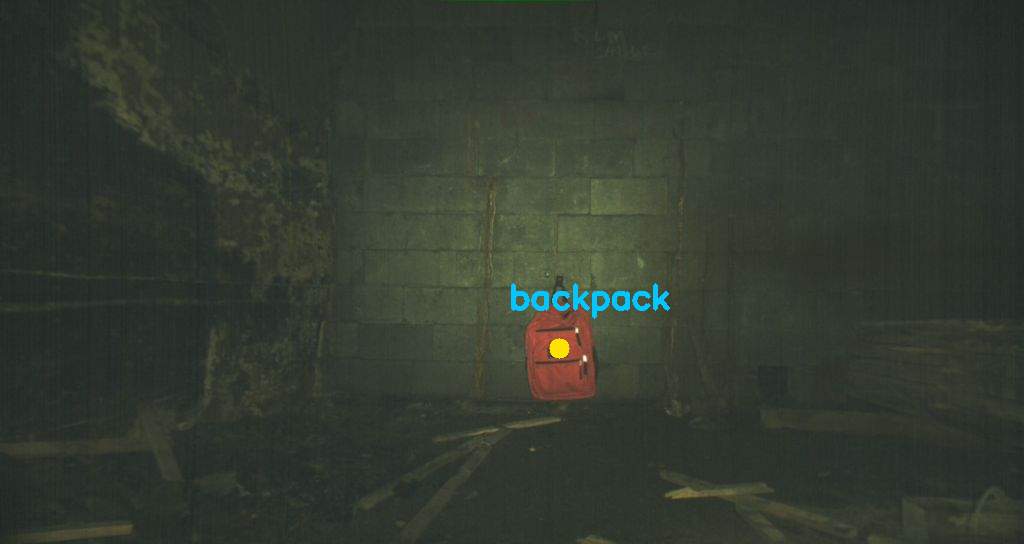

In [ ]:
cv2_imshow(result_2[227])

Store result to hdf5

In [ ]:
write_hdf5(result_1,'/content/result_1.hdf5')

In [ ]:
write_hdf5(result_2,'/content/result_FCN_vent.hdf5')

read hdf5

In [ ]:
output_file_ = '/content/result_1.hdf5'
result_ = read_img(output_file_)

In [ ]:
output_file = '/content/result_FCN_vent.hdf5'
result__ = read_img(output_file)

image
/image
(300, 544, 1024, 3)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:8: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  


show image

In [ ]:
for i in range(300):
  print(i)
  plt.imshow(result__[0][i][:,:,[2,1,0]])
  plt.show()

Output hidden; open in https://colab.research.google.com to view.

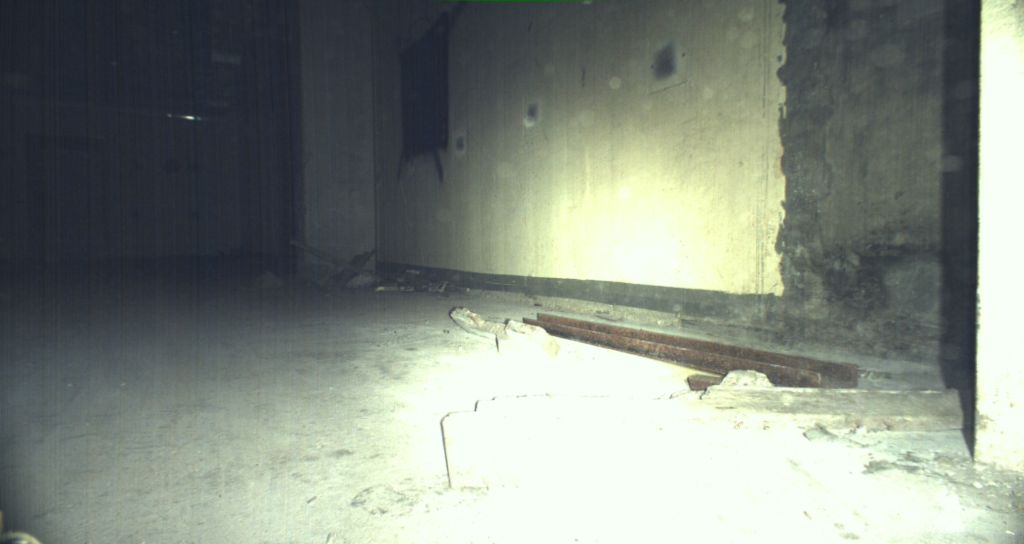

In [ ]:
cv2_imshow(result__[0][295])